1. Load Bayesian CNN model as Annotator
2. Active Learning will query the samples based on its acquistion function
3. Queried samples will be sent to BCNN for labelling.
4. Only those labels will be submitted whose labels are confidently returned by the BCNN model. 
5. Active Learning Model will be retrained.

In [ ]:
from copy import deepcopy
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow.keras as tfk
tfkl=tfk.layers
from tensorflow.keras.models import Model

In [ ]:
num_base_filters=32
l2_reg=1e-4  #1e-4
dropout_rate=0.5  #0.15 for case3  ## for MC-Dropout
learning_rate=1e-4
bs=64

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_model():
  inputs=tfkl.Input((224,224,3))
  x=tfkl.Conv2D(filters=num_base_filters,kernel_size=3,strides=(1, 1),padding="same",kernel_regularizer=tfk.regularizers.l2(l2_reg))(inputs)
  x=tfkl.LeakyReLU()(x)
  #x=tfkl.Dropout(dropout_rate)(x,training=True)
  #x=tfkl.BatchNormalization()(x)
  x=tfkl.Conv2D(filters=num_base_filters,kernel_size=3,strides=(1, 1),padding="same",kernel_regularizer=tfk.regularizers.l2(l2_reg))(x)
  x=tfkl.LeakyReLU()(x)
  x=tfkl.Dropout(dropout_rate)(x,training=True)
  x=tfkl.BatchNormalization()(x)
  x=tfkl.MaxPooling2D(pool_size=3, strides=(2, 2), padding="same")(x)
  #Block2
  x=tfkl.Conv2D(filters=num_base_filters*2,kernel_size=3,strides=(1, 1),padding="same",kernel_regularizer=tfk.regularizers.l2(l2_reg))(x)
  x=tfkl.LeakyReLU()(x)
  #x=tfkl.Dropout(dropout_rate)(x,training=True)
  #x=tfkl.BatchNormalization()(x)
  x=tfkl.Conv2D(filters=num_base_filters*2,kernel_size=3,strides=(1, 1),padding="same",kernel_regularizer=tfk.regularizers.l2(l2_reg))(x)
  x=tfkl.LeakyReLU()(x)
  x=tfkl.Dropout(dropout_rate)(x,training=True)
  x=tfkl.BatchNormalization()(x)
  x=tfkl.MaxPooling2D(pool_size=3, strides=(2, 2), padding="same")(x)
  #Block3
  x=tfkl.Conv2D(filters=num_base_filters*4,kernel_size=3,strides=(1, 1),padding="same",kernel_regularizer=tfk.regularizers.l2(l2_reg))(x)
  x=tfkl.LeakyReLU()(x)
  #x=tfkl.Dropout(dropout_rate)(x,training=True)
  #x=tfkl.BatchNormalization()(x)
  x=tfkl.Conv2D(filters=num_base_filters*4,kernel_size=3,strides=(1, 1),padding="same",kernel_regularizer=tfk.regularizers.l2(l2_reg))(x)
  x=tfkl.LeakyReLU()(x)
  x=tfkl.Dropout(dropout_rate)(x,training=True)
  x=tfkl.BatchNormalization()(x)
  x=tfkl.MaxPooling2D(pool_size=3, strides=(2, 2), padding="same")(x)
  # Block 4
  x=tfkl.Conv2D(filters=num_base_filters*8,kernel_size=3,strides=(1, 1),padding="same",kernel_regularizer=tfk.regularizers.l2(l2_reg))(x)
  x=tfkl.LeakyReLU()(x)
  #x=tfkl.Dropout(dropout_rate)(x,training=True)
  #x=tfkl.BatchNormalization()(x)
  x=tfkl.Conv2D(filters=num_base_filters*8,kernel_size=3,strides=(1, 1),padding="same",kernel_regularizer=tfk.regularizers.l2(l2_reg))(x)
  x=tfkl.LeakyReLU()(x)
  #x=tfkl.Dropout(dropout_rate)(x,training=True)
  #x=tfkl.BatchNormalization()(x)
  x=tfkl.Conv2D(filters=num_base_filters*8,kernel_size=3,strides=(1, 1),padding="same",kernel_regularizer=tfk.regularizers.l2(l2_reg))(x)
  x=tfkl.LeakyReLU()(x)
  x=tfkl.Dropout(dropout_rate)(x,training=True)
  x=tfkl.BatchNormalization()(x)
  x=tfkl.MaxPooling2D(pool_size=5, strides=(3, 3), padding="same")(x)
  # Block 5
  x=tfkl.Conv2D(filters=num_base_filters*8,kernel_size=3,strides=(1, 1),padding="same",kernel_regularizer=tfk.regularizers.l2(l2_reg))(x)
  x=tfkl.LeakyReLU()(x)
  #x=tfkl.Dropout(dropout_rate)(x,training=True)
  #x=tfkl.BatchNormalization()(x)
  x=tfkl.Conv2D(filters=num_base_filters*8,kernel_size=3,strides=(1, 1),padding="same",kernel_regularizer=tfk.regularizers.l2(l2_reg))(x)
  x=tfkl.LeakyReLU()(x)
  #x=tfkl.Dropout(dropout_rate)(x,training=True)
  #x=tfkl.BatchNormalization()(x)
  x=tfkl.Conv2D(filters=num_base_filters*8,kernel_size=3,strides=(1, 1),padding="same",kernel_regularizer=tfk.regularizers.l2(l2_reg))(x)
  x=tfkl.LeakyReLU()(x)
  x=tfkl.Dropout(dropout_rate)(x,training=True)
  x=tfkl.BatchNormalization()(x)
  x=tfkl.MaxPooling2D(pool_size=5, strides=(3, 3), padding="same")(x)
  #x=tfkl.Lambda(lambda y: tfk.backend.concatenate([tfkl.GlobalAvgPool2D()(y),tfkl.GlobalMaxPool2D()(y)], axis=1))(x)
  x=tfkl.Flatten()(x)
  # Fully-connected
  x=tfkl.Dense(2048)(x)
  x=tfkl.LeakyReLU()(x)
  x=tfkl.Dropout(0.5)(x,training=True)
  x=tfkl.BatchNormalization()(x)
  x=tfkl.Dense(512)(x)
  x=tfkl.LeakyReLU()(x)
  x=tfkl.Dropout(0.5)(x,training=True)
  x=tfkl.BatchNormalization()(x)
  x=tfkl.Dense(128)(x)
  x=tfkl.LeakyReLU()(x)
  x=tfkl.Dropout(0.2)(x,training=True)
  x=tfkl.BatchNormalization()(x)
  outputs=tfkl.Dense(5,activation='softmax')(x)
  model=Model(inputs,outputs)
  return model

In [ ]:
model=get_model()
model.load_weights("/content/drive/My Drive/CNN_best_model_multi_class_ce-new.h5")

In [ ]:
for layer in model.layers:
  layer.trainable=False
for layer in intermediate_model.layers:
  layer.trainable=False

In [ ]:
print(intermediate_model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128 

In [ ]:
X_O=[]
y_O=[]
X_F=[]
y_F=[]
import glob
import cv2
def make_arrays(dir):
  for folders in dir:
    print(folders)
    for folder in folders:
      print(folder)
      label=int(folder[len(folder)-1])
      fldr= folder.split("/")
      fldr=fldr[len(fldr)-2]
      if (fldr=="test" and label==0) or (fldr=="test" and label==1) or (fldr=="test" and label==2):
        print(fldr)
        print(label)
        continue;
      else:
        files=glob.glob(folder + "/*")
        #print(len(files))
        for file in files:
          res=cv2.cvtColor(cv2.resize(cv2.imread(file),(224,224)), cv2.COLOR_BGR2RGB)/255.0
          X_O.append(res)
          res=np.expand_dims(res,axis=0)
          X_F.append(np.squeeze(intermediate_model(res,training=True),axis=0))
          y_O.append(label)
          y_F.append(label)
  return np.array(X_O),np.array(y_O),np.array(X_F),np.array(y_F)

In [ ]:
filesv=glob.glob("/content/drive/My Drive/Multiclass Dataset New/val/*")
filest=glob.glob("/content/drive/My Drive/Multiclass Dataset New/test/*")
import tensorflow as tf
X_O,y_O,X_F,y_F=make_arrays([filesv,filest])

y_O=tf.keras.utils.to_categorical(y_O, num_classes=5, dtype='float32')
y_F=tf.keras.utils.to_categorical(y_F, num_classes=5, dtype='float32')
print("X Orig : ",X_O.shape)
print("y Orig : ",y_O.shape)
print("X Feat : ",X_F.shape)
print("y_Feat : ",y_F.shape)
# np.save("/content/X_F.npy",X_F)
# np.save("/content/y_F.npy",y_F)
# np.save("/content/X_O.npy",X_O)
# np.save("/content/y_O.npy",y_O)

['/content/drive/My Drive/Multiclass Dataset New/val/0', '/content/drive/My Drive/Multiclass Dataset New/val/1', '/content/drive/My Drive/Multiclass Dataset New/val/2', '/content/drive/My Drive/Multiclass Dataset New/val/3', '/content/drive/My Drive/Multiclass Dataset New/val/4']
/content/drive/My Drive/Multiclass Dataset New/val/0
/content/drive/My Drive/Multiclass Dataset New/val/1
/content/drive/My Drive/Multiclass Dataset New/val/2
/content/drive/My Drive/Multiclass Dataset New/val/3
/content/drive/My Drive/Multiclass Dataset New/val/4
['/content/drive/My Drive/Multiclass Dataset New/test/0', '/content/drive/My Drive/Multiclass Dataset New/test/1', '/content/drive/My Drive/Multiclass Dataset New/test/2', '/content/drive/My Drive/Multiclass Dataset New/test/3', '/content/drive/My Drive/Multiclass Dataset New/test/4']
/content/drive/My Drive/Multiclass Dataset New/test/0
test
0
/content/drive/My Drive/Multiclass Dataset New/test/1
test
1
/content/drive/My Drive/Multiclass Dataset New

In [ ]:
p=np.random.permutation(range(0,len(X_F)))
X_O=X_O[p]
y_O=y_O[p]
X_F=X_F[p]
y_F=y_F[p]

In [ ]:
n_inctances=300
train_idx = np.random.choice(range(X_F.shape[0]), size=n_inctances, replace=False)
X_initial=X_F[train_idx]
y_initial=y_F[train_idx]
print(X_initial.shape)    
print(y_initial.shape)


(300, 10, 10, 256)
(300, 5)


In [ ]:
X_O = np.delete(X_O, train_idx, axis=0)
y_O = np.delete(y_O, train_idx, axis=0)
X_F = np.delete(X_F, train_idx, axis=0)
y_F = np.delete(y_F, train_idx, axis=0)
print(X_O.shape)
print(y_O.shape)
print(X_F.shape)
print(y_F.shape)

(1938, 224, 224, 3)
(1938, 5)
(1938, 10, 10, 256)
(1938, 5)


In [ ]:
X_pool= X_F[0:int(0.70*X_F.shape[0])]
X_orig= X_O[0:int(0.70*X_O.shape[0])]
y_O = y_O[0:int(0.70*X_O.shape[0])]
print(X_pool.shape)
print(X_orig.shape)
print(y_O.shape)

(1356, 10, 10, 256)
(1356, 224, 224, 3)
(1356, 5)


In [ ]:
X_test= X_F[int(0.70*X_F.shape[0]):]
y_test = y_F[int(0.70*y_F.shape[0]):]
print(X_test.shape)    
print(y_test.shape)

(582, 10, 10, 256)
(582, 5)


In [ ]:
def focal_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [ ]:
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import Model
opt=Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999)
def create_keras_model():
  inputs=tfkl.Input((10,10,256))
  x=tfkl.Conv2D(256,3,strides=1,padding='valid',kernel_regularizer=tfk.regularizers.l2(1e-3))(inputs)
  x=tfkl.LeakyReLU()(x)
  x=tfkl.Dropout(0.35)(x,training=True)
  x=tfkl.BatchNormalization()(x)
  x=tfkl.MaxPool2D(pool_size=(2,2),strides=2)(x)
  x=tfkl.Conv2D(256,3,strides=1,padding='same')(x)
  x=tfkl.LeakyReLU()(x)
  x=tfkl.Dropout(0.35)(x,training=True)
  x=tfkl.BatchNormalization()(x)
  x=tfkl.Conv2D(256,3,strides=1,padding='same')(x)
  x=tfkl.LeakyReLU()(x)
  x=tfkl.Dropout(0.35)(x,training=True)
  x=tfkl.BatchNormalization()(x)
  x=tfkl.Flatten()(x)
  x=tfkl.Dense(2048,kernel_regularizer=tfk.regularizers.l2(1e-3))(x)
  x=tfkl.LeakyReLU()(x)
  x=tfkl.Dropout(0.35)(x,training=True)
  x=tfkl.BatchNormalization()(x)
  x=tfkl.Dense(512,kernel_regularizer=tfk.regularizers.l2(1e-3))(x)
  x=tfkl.LeakyReLU()(x)
  x=tfkl.Dropout(0.25)(x,training=True)
  x=tfkl.BatchNormalization()(x)
  x=tfkl.Dense(128,kernel_regularizer=tfk.regularizers.l2(1e-3))(x)
  x=tfkl.LeakyReLU()(x)
  x=tfkl.Dropout(0.25)(x,training=True)
  x=tfkl.BatchNormalization()(x)
  x=tfkl.Dense(5,kernel_regularizer=tfk.regularizers.l2(1e-3),activation='softmax')(x)
  al_model=Model(inputs,x)
  al_model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
  return al_model

In [ ]:
classifier = create_keras_model()
classifier.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 10, 256)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 256)         590080    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 256)         5900

In [ ]:
def Uncertainty_Quantification(x,model,num_samples):
  mc_samples=np.array([model(x,training=False) for _ in range(num_samples)])
  mc_samples=np.squeeze(mc_samples,axis=1)
  mean_mc_samples=np.mean(mc_samples,axis=0)
  y_pred=np.argmax(mean_mc_samples)
  ent=-1*np.sum(np.multiply(mean_mc_samples,np.log(mean_mc_samples)),axis=0)
  return ent,mean_mc_samples

In [ ]:
def query(x,query_strategy="uncertainty_sampling"):
  mc_samples=np.array([classifier(x) for _ in range(10)])
  mean_mc_samples=np.mean(mc_samples,axis=0)
  if query_strategy=="uncertainty_sampling":
    uncer= 1-mean_mc_samples.max(axis=1)
    query_index= np.argmax(uncer)
  return query_index

In [ ]:
def get_class_weights(y):
  from sklearn.utils import class_weight
  y_hat=np.argmax(y,axis=1)
  class_weights = class_weight.compute_class_weight('balanced',np.unique(y_hat),y_hat)
  if class_weights.shape[0]==5:
    ws = dict({0: class_weights[0],1: class_weights[1],2: class_weights[2],3: class_weights[3],4: class_weights[4]})
  else:
     ws = None
  return ws

In [ ]:
def evaluate(y_pred,y_true):
  count=0
  for i in range(0,y_pred.shape[0]):
    if y_pred[i]==y_true[i]:
      count+=1
  return count/y_pred.shape[0]

In [ ]:
class_weights=get_class_weights(y_O)
print(class_weights)

{0: 0.562655601659751, 1: 1.2672897196261683, 2: 1.0233962264150944, 3: 1.4739130434782608, 4: 1.2853080568720379}


In [ ]:
classifier.fit(X_pool,y_O,epochs=10,verbose=1,batch_size=16,class_weight=class_weights)
class_weight=get_class_weights(y_O)
y_pred=np.argmax(classifier(X_test),axis=1)
y_true=np.argmax(y_test,axis=1)
# print(y_pred.shape)
# print(y_true.shape)
#classifier.save_weights("cnn_multi_ce_weights.h5")
print("Initial Test Accuracy",evaluate(y_pred,y_true))

#classifier.load_weights("/content/Al_model_CNN_PBS.h5")

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
85/85 [==============================] - 6s 23ms/step - loss: 5.3903 - accuracy: 0.5199
Epoch 2/10
85/85 [==============================] - 2s 21ms/step - loss: 4.9105 - accuracy: 0.6925
Epoch 3/10
85/85 [==============================] - 2s 21ms/step - loss: 4.6819 - accuracy: 0.7736
Epoch 4/10
85/85 [==============================] - 2s 21ms/step - loss: 4.5927 - accuracy: 0.7869
Epoch 5/10
85/85 [==============================] - 2s 21ms/step - loss: 4.4781 - accuracy: 0.8252
Epoch 6/10
85/85 [==============================] - 2s 21ms/step - loss: 4.4179 - accuracy: 0.8385
Epoch 7/10
85/85 [==============================] - 2s 21ms/step - loss: 4.3244 - accuracy: 0.8732
Epoch 8/10
85/85 [==============================] - 2s 21ms/step - loss: 4.2614 - accuracy: 0.8695
Epoch 9/10
85/85 [==============================] - 2s 21ms/step - los

In [ ]:
#classifier.compile(loss=focal_loss(gamma=2., alpha=4.),optimizer=opt,metrics=['accuracy'])
#classifier.load_weights("cnn_multi_ce_weights.h5")

In [ ]:
N_QUERIES = 1000
scor=[]
xtr=[]
ytr=[]
index=0
while (index < N_QUERIES):
  index+=1
  p=np.random.permutation(range(X_pool.shape[0]))
  X_pool=X_pool[p]
  X_orig=X_orig[p]
  y_O=y_O[p]
  pool_f=X_pool[0:20]
  pool_o=X_orig[0:20]
  pool_y= y_O[0:20]
  query_index=query(pool_f,query_strategy="uncertainty_sampling")
  x=np.expand_dims(pool_o[query_index],axis=0)
  # print(x.shape)
  ent,mean_mc_prob=Uncertainty_Quantification(x,model,10)
  y_pred=tf.keras.utils.to_categorical(np.argmax(mean_mc_prob), num_classes=5, dtype='float32')
  if ent < 1.276:
    xtr.append(pool_f[query_index])
    ytr.append(y_O[query_index])
  if index % 16 == 0:
    #print("Remaining Pool Size",X_pool.shape[0])
    xtr=np.array(xtr)
    ytr=np.array(ytr)
    bs=16;
    X_initial=np.concatenate((xtr,X_initial),axis=0)
    y_initial=np.concatenate((ytr,y_initial),axis=0)
    #print("New Training Size:",y_initial.shape[0])
    print(get_class_weights(y_initial))
    hist=classifier.fit(X_initial,y_initial,epochs=25,verbose=0,batch_size=bs,shuffle=True,class_weight=get_class_weights(y_initial))
    y_pred_test=np.argmax(classifier(X_test),axis=1)
    y_true_test=np.argmax(y_test,axis=1)
    scr=evaluate(y_pred_test,y_true_test)
    scor.append(scr)
    print("Test Accuracy after Iteration:",index,scr)
    xtr=[]
    ytr=[]
  X_pool = np.delete(X_pool, query_index, axis=0)
  X_orig= np.delete(X_orig, query_index, axis=0)
  y_O= np.delete(y_O, query_index, axis=0)

{0: 0.6383838383838384, 1: 1.3446808510638297, 2: 0.8540540540540541, 3: 1.6631578947368422, 4: 1.089655172413793}
Test Accuracy after Iteration: 16 0.8814432989690721
{0: 0.6574257425742575, 1: 1.328, 2: 0.8405063291139241, 3: 1.6195121951219513, 4: 1.0885245901639344}
Test Accuracy after Iteration: 32 0.8780068728522337
{0: 0.689108910891089, 1: 1.392, 2: 0.8093023255813954, 3: 1.5466666666666666, 4: 1.0545454545454545}
Test Accuracy after Iteration: 48 0.8934707903780069
{0: 0.7137254901960784, 1: 1.3735849056603773, 2: 0.8088888888888889, 3: 1.456, 4: 1.055072463768116}
Test Accuracy after Iteration: 64 0.8917525773195877
{0: 0.7450980392156863, 1: 1.3333333333333333, 2: 0.7835051546391752, 3: 1.4615384615384615, 4: 1.0555555555555556}
Test Accuracy after Iteration: 80 0.8814432989690721
{0: 0.7745098039215687, 1: 1.3166666666666667, 2: 0.7821782178217822, 3: 1.4107142857142858, 4: 1.0394736842105263}
Test Accuracy after Iteration: 96 0.8573883161512027
{0: 0.7903846153846154, 1: 1

In [ ]:
import numpy as np
np.save("/content/CNN_Multi_PBS_ce_Only_31MAY2021.npy",scor)

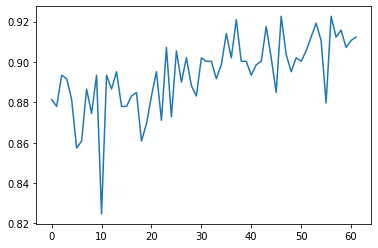

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(scor)

In [ ]:
print(scor[len(scor)-1])

0.9123711340206185


In [ ]:
preds=np.argmax(classifier(X_test),axis=1)
actuals=np.argmax(y_test,axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix


In [ ]:
O = confusion_matrix(actuals, preds); O

array([[232,   0,   1,   0,   0],
       [  3,  69,   1,   0,   1],
       [  6,   8,  92,   3,   5],
       [  0,   2,   9,  60,   3],
       [  2,   2,   7,   1,  75]])

In [ ]:
w = np.zeros((5,5)); w

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [ ]:
for i in range(len(w)):
    for j in range(len(w)):
        w[i][j] = float(((i-j)**2)/16)

In [ ]:
N=5
act_hist=np.zeros([N])
for item in actuals: 
    act_hist[item]+=1
    
pred_hist=np.zeros([N])
for item in preds: 
    pred_hist[item]+=1

In [ ]:
print(f'Actuals value counts:{act_hist}, Prediction value counts:{pred_hist}')

Actuals value counts:[233.  74. 114.  74.  87.], Prediction value counts:[243.  81. 110.  64.  84.]


In [ ]:
E = np.outer(act_hist, pred_hist); E

array([[56619., 18873., 25630., 14912., 19572.],
       [17982.,  5994.,  8140.,  4736.,  6216.],
       [27702.,  9234., 12540.,  7296.,  9576.],
       [17982.,  5994.,  8140.,  4736.,  6216.],
       [21141.,  7047.,  9570.,  5568.,  7308.]])

In [ ]:
E = E/E.sum(); E.sum()

1.0

In [ ]:
O = O/O.sum(); O.sum()

1.0

In [ ]:
num=0
den=0
for i in range(len(w)):
    for j in range(len(w)):
        num+=w[i][j]*O[i][j]
        den+=w[i][j]*E[i][j]
 
weighted_kappa = (1 - (num/den)); weighted_kappa

0.9328054381129727